In [35]:
import numpy as np
import math
import pandas as pd

from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn as nn, optim as optim, functional as F
from datetime import datetime

# A 

In [36]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [37]:
A = np.array([
    [(math.sqrt(99))/10, -1/10],
    [1/10, (math.sqrt(99))/10]
    ])

B = np.array([
    [math.sqrt(2)/2,-2/2],
    [math.sqrt(2)/2,math.sqrt(2)/2]
])


eps1 = np.random.normal(loc=0, scale=0.2, size=[2, 2000])
eps2 = np.random.normal(loc=0, scale=0.2**2, size=[2, 2000])


x0 = np.array([1,0])+eps1[:,0] #do we need to add noise to XO?
y0 = B.dot(x0) + eps2[:,0] #not true- how do w know the real YO?

length = 2000
train_size = 1000
test_size = 1000

x, y_hat = [x0], [y0]

for i in range (length-1):
  # X(k+1) = AX(k) + ϵ1(k+1)
  x_next = a.dot(x[i]) + eps1[:, i+1]
  x.append(x_next)
  #Y(k+1) = BX(k+1) + ϵ2(k+1)
  y_next = b.dot(x_next) + eps2[:, i+1]
  y_hat.append(y_next)
  i = i+1

#need to update x_hat[i] accordingly
X = pd.DataFrame(x)
y = pd.DataFrame(y_hat)

LSTM cells:


*   C*t-1*- Cell state/Long-term memory- (last time stemp output)
*   Hidden-State (Short term memmory)- H*t-1*
*   Input- Y*t-1* (last time stemp output)


INITILAZATIONS:
H0,C0- tensors of Zeroes. in the backpopagation stage the network will learn these states by vy theire deriviations according to the loss functions.

Stages:
1.  Forget gate- Values between 0 to 1=> sigmoid(W *forget* (H*t-1*,Y*t-1*)+BIAS *forget* ) * C*t-1*

2.  Input gate- - Values between -1 to 1==> sigmoid(Wi1(H*t-1*,Y*t-1*)+BIASi1) * tanjh(Wi2(H*t-1*,Y*t-1*)+BIASi2)

>>The outcome represents the information to be kept in the long-term memory and used as the output. As the layer is being trained through back-propagation, the weights in the sigmoid function will be updated such that it learns to only let the useful pass through while discarding the less critical features

3.  1+2: will define our C**t** value (New Long term memmory)

4.  sigmoid(W output1 (H*t-1*,Y*t-1*)+BIAS output1) * tan (W output1(C**t**) + BIAS output2)- will define our output (Y_hat **t**) and out new Hidden state (H_hat **t**)  
>First, the previous short-term memory and current input (H*t-1*,Y*t-1*) will be passed into a sigmoid function (Yes, this is the 3rd time we’re doing this) with different weights yet again to create the third and final filter. Then, we put the new long-term memory (C**t**) through an activation tanh function. The output from these 2 processes will be multiplied to produce the new short-term memory ( H**t**). The short-term ( H**t**) and long-term memory (C**t**) produced by these gates will then be carried over to the next cell for the process to be repeated. The output of each time step can be obtained ( Y**t**) from the short-term memory, also known as the hidden state.

#https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b



## Building the sets

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_val_test_split(X, y,val_ratio, test_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X , y, 0.2, 0.5)

scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [39]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 64
layer_dim = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6
batch_size =50

train_features = torch.Tensor(X_train_arr) #torch.Size([800, 2])
train_targets = torch.Tensor(y_train_arr) #torch.Size([800, 2])
val_features = torch.Tensor(X_val_arr)  #torch.Size([200, 2])
val_targets = torch.Tensor(y_val_arr)  #torch.Size([200, 2])
test_features = torch.Tensor(X_test_arr)  #torch.Size([1000, 2])
test_targets = torch.Tensor(y_test_arr) 

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)


In [40]:
import os

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        # h0 = torch(self.layer_dim, x.size(0), self.hidden_dim)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        #print('hn shape:', hn.shape, 'hn:',hn,'cn shape:', cn.shape, 'cn:',cn )
        print('hn shape:', hn.shape)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size) so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (hidden_dim, output_dim)
        out = self.fc(out)

        return out
    
def get_model(model, model_params):
    models = {
        # "rnn": RNNModel,
        "lstm": LSTMModel#,
        # "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [41]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
   
    def train_step(self, x, y): #for single batch
        # Sets model to train mode
        self.model.train()

        # Makes predictions per batch (x is the batch)
        yhat = self.model(x)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        # print("y",y, "Yhat",yhat,"Loss",loss)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()


    def train(self, train_loader, val_loader, batch_size=10, n_epochs=50, n_features=2):
            # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
            model_path = f"{os.getcwd()}/model.pth"

            for epoch in range(1, n_epochs + 1):   

              #for train set:
                batch_losses = []                      
                for x_batch, y_batch in train_loader:
                    x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                    y_batch = y_batch.to(device)
                    loss = self.train_step(x_batch, y_batch)
                    batch_losses.append(loss)
                training_loss = np.mean(batch_losses)
                print ('batch_loses_size',len(batch_losses))
                self.train_losses.append(training_loss)

              #for val: torch.no_grad() means that we dont want to calculate gradient for the backpropagation- because it's validation/test set and not train set  
                with torch.no_grad(): 
                    batch_val_losses = []
                    for x_val, y_val in val_loader:
                        x_val = x_val.view([batch_size, -1, n_features]).to(device)
                        y_val = y_val.to(device)
                        self.model.eval()
                        yhat = self.model(x_val)
                        val_loss = self.loss_fn(y_val, yhat).item()
                        batch_val_losses.append(val_loss)
                    validation_loss = np.mean(batch_val_losses)
                    self.val_losses.append(validation_loss)

                if (epoch <= 10) | (epoch % 50 == 0):
                    print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

            torch.save(self.model.state_dict(), model_path)
    
    def plot_losses(self):
          plt.plot(self.train_losses, label="Training loss")
          plt.plot(self.val_losses, label="Validation loss")
          plt.legend()
          plt.title("Losses")
          plt.show()
          plt.close()

    def evaluate(self, test_loader, batch_size=1, n_features=2):
      with torch.no_grad(): #torch.no_grad() means that we dont want to calculate gradient for the backpropagation- because it's validation/test set and not train set
          predictions = []
          values = []
          test_error = []

          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.to(device).detach().numpy())
              values.append(y_test.to(device).detach().numpy())
              error = self.loss_fn(y_test, yhat).item()
              test_error.append(error)
          mean_error = np.mean(test_error)
          # self.error.append(mean_error)

      return predictions, values,test_error

hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
batch_loses_size 16
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
[1/100] Training loss: 0.2412	 Validation loss: 0.2583
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shap

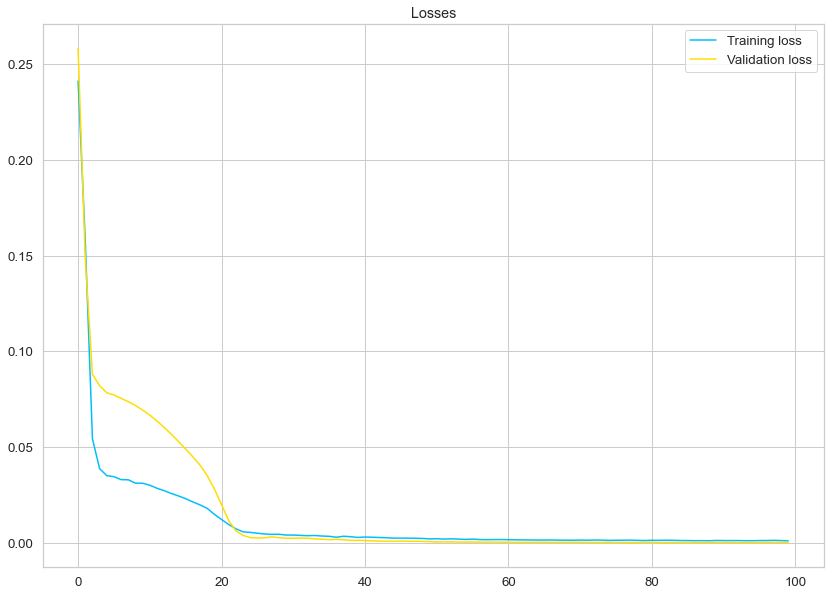

hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: 

,X1,X2,y1,y2,y1_predicted,y2_predicted
0,0.785874,0.565169,0.630557,0.754404,0.630633,0.769091
1,0.788333,0.583089,0.617468,0.763896,0.617387,0.782584
2,0.781180,0.605383,0.593143,0.778881,0.595036,0.792395
3,0.765481,0.648507,0.551181,0.795823,0.550892,0.809664
4,0.757935,0.677248,0.525074,0.812134,0.523420,0.822689
...,...,...,...,...,...,...
995,1.014432,0.013467,1.213313,0.537780,1.144778,0.548111
996,1.060364,0.046351,1.215417,0.590289,1.143859,0.600613
997,1.095109,0.100386,1.188668,0.650792,1.125102,0.658994
998,1.131001,0.176252,1.151118,0.734089,1.091644,0.731586


In [42]:
model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    'output_dim' : output_dim,
    'dropout_prob' : dropout
}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay) 

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

error=pd.Series(error)
error.abs().mean()

#Results dataFrame:
predictions=pd.DataFrame(preds)
predictions.rename(columns={0: 'y1_predicted', 1: 'y2_predicted'}, inplace=True)
values=pd.DataFrame(vals)
values.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)


x_test_arr=pd.DataFrame(X_test_arr)
x_test_arr.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

frames = [x_test_arr,results] 
df_result = pd.concat(frames, axis=1)

results

df_result


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {
        'mae' : mean_absolute_error(vals, preds),
        'rmse' : mean_squared_error(vals, preds) ** 0.5,
        'r2' : r2_score(vals, preds)
    }

result_metrics = calculate_metrics(df_result)
result_metrics

{'mae': 0.02095186, 'rmse': 0.030094199676795903, 'r2': 0.9923948526104808}

hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
batch_loses_size 16
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
[1/100] Training loss: 0.2181	 Validation loss: 0.2385
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shape: torch.Size([3, 50, 64])
hn shap

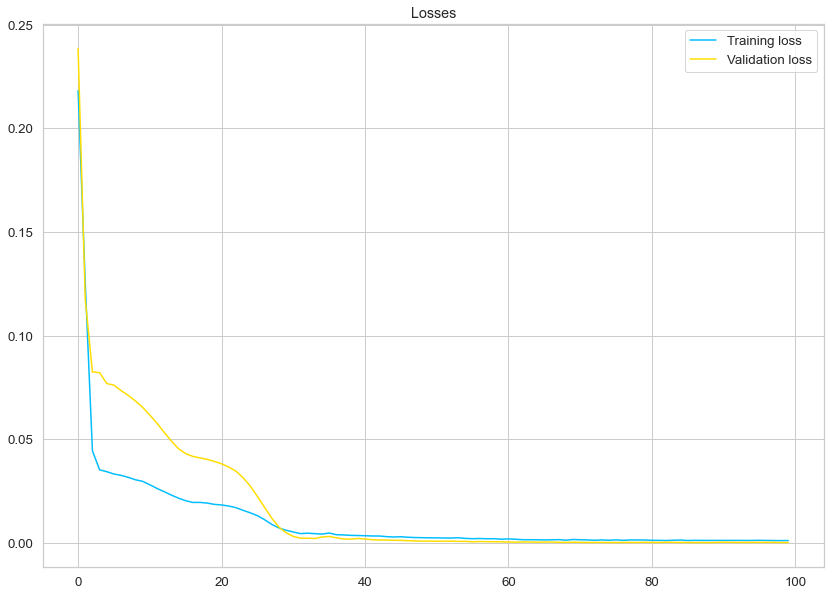

hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: torch.Size([3, 1, 64])
hn shape: 

{'mae': 0.019654784, 'rmse': 0.02822087255041987, 'r2': 0.9932218771461845}

In [45]:
"""#Predict X

Change X to be target and Y to be features
"""

#put the data into tensors
train_features = torch.Tensor(y_train_arr) #torch.Size([800, 2])
train_targets = torch.Tensor(X_train_arr) #torch.Size([800, 2])
val_features = torch.Tensor(y_val_arr)  #torch.Size([200, 2])
val_targets = torch.Tensor(X_val_arr)  #torch.Size([200, 2])
test_features = torch.Tensor(y_test_arr)  #torch.Size([1000, 2])
test_targets = torch.Tensor(X_test_arr)  #torch.Size([1000, 2])

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

#DataLoader wraps an iterable around the Dataset to enable easy access to the samples:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('lstm', model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay) 
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values, error = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

#Results dataFrame:
predictions=pd.DataFrame(preds)
predictions.rename(columns={0: 'X1_predicted', 1: 'X2_predicted'}, inplace=True)
values=pd.DataFrame(vals)
values.rename(columns={0: 'X1', 1: 'X2'}, inplace=True)

results = pd.concat([values, predictions], axis=1)

y_test_arr=pd.DataFrame(y_test_arr)
y_test_arr.rename(columns={0: 'y1', 1: 'y2'}, inplace=True)

frames = [y_test_arr,results] 
df_result_x = pd.concat(frames, axis=1)

df_result

df_result_x

# def inverse_transform(scaler, df):
#     for col in df.columns:
#         df[col] = scaler.inverse_transform(df[col])
#     return df\


# df_result_x = inverse_transform(scaler, df_result_x)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(vals, preds),
            'rmse' : mean_squared_error(vals, preds) ** 0.5,
            'r2' : r2_score(vals, preds)}

result_metrics = calculate_metrics(df_result_x)
result_metrics